In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import math
from statsmodels.tsa.stattools import adfuller
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [3]:
def create_features(df, x):
    df['month'] = df[x].dt.strftime('%B')
    df['year'] = df[x].dt.strftime('%Y')
    df['dayofweek'] = df[x].dt.strftime('%A')
    df['quarter'] = df[x].dt.quarter
    df['dayofyear'] = df[x].dt.dayofyear
    df['dayofmonth'] = df[x].dt.day
    df['weekofyear'] = df[x].dt.isocalendar().week
    return df

In [4]:
def eval_metrics(actual, forecast):
    n = len(actual)
#     mape = np.mean(np.abs((actual - forecast)/actual))*100
    mape = np.mean(np.abs((actual - abs(forecast)) / actual) * 100)
    smape = (1/n) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))) * 100
    mae = np.abs(forecast - actual).mean()
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    return mape, smape, mae, rmse

In [5]:
df = pd.read_excel('UoS Energy Consumption.xlsx', sheet_name='total consmp_for_forecast')

In [6]:
df.head(5)

,date_time,consumption
0,2005-07-01,1227356.0
1,2005-08-01,1189818.0
2,2005-09-01,1271609.0
3,2005-10-01,1553131.0
4,2005-11-01,1557021.0


In [7]:
df = df[['date_time', 'consumption']]

In [8]:
df = df.rename(columns={'date_time': 'ds', 'consumption': 'y'})

In [9]:
df = df[df['ds'] >= '2009-01-01']

In [10]:
df = create_features(df, 'ds')
df.head(5)

,ds,y,month,year,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
42,2009-01-01,5.434464e+06,January,2009,Thursday,1,1,1,1
43,2009-02-01,4.752303e+06,February,2009,Sunday,1,32,1,5
44,2009-03-01,5.151501e+06,March,2009,Sunday,1,60,1,9
45,2009-04-01,4.084587e+06,April,2009,Wednesday,2,91,1,14
46,2009-05-01,3.776160e+06,May,2009,Friday,2,121,1,18


In [11]:
plt.style.use('fivethirtyeight')

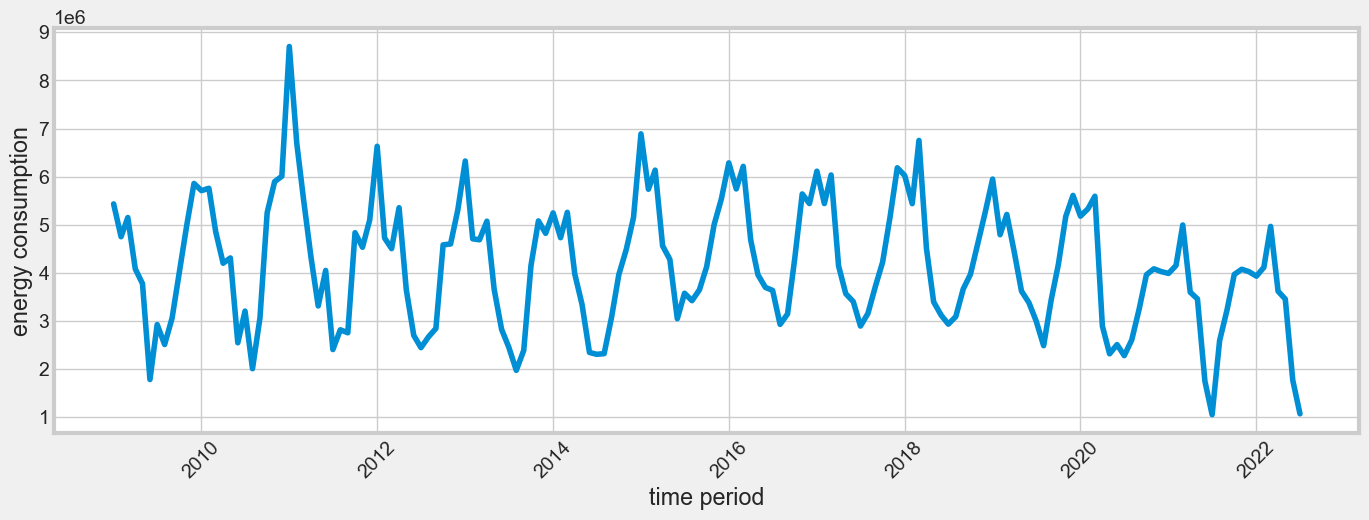

In [12]:
# plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')
sns.lineplot(x='ds', y='y', data=df)
plt.xlabel("time period")
plt.ylabel("energy consumption")
plt.xticks(rotation=45)
plt.show()

# train test split

In [13]:
training_limit = int( 0.80 * len(df))
train_data = df[:training_limit]
test_data = df[training_limit:]

In [14]:
train_data.tail(5)

,ds,y,month,year,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
167,2019-06-01,3380377.8,June,2019,Saturday,2,152,1,22
168,2019-07-01,2999190.0,July,2019,Monday,3,182,1,27
169,2019-08-01,2486960.4,August,2019,Thursday,3,213,1,31
170,2019-09-01,3430260.2,September,2019,Sunday,3,244,1,35
171,2019-10-01,4171562.0,October,2019,Tuesday,4,274,1,40


# Model

In [15]:
from prophet import Prophet

model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.5, 
                holidays_prior_scale=0.1, n_changepoints=200)
model.add_country_holidays(country_name='UK')
model.fit(train_data)

13:28:19 - cmdstanpy - INFO - Chain [1] start processing
13:28:19 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = model.make_future_dataframe(periods=3655)
forecast = model.predict(future)

In [17]:
forecast[['ds', 'yhat', 'trend', 'yhat_lower', 'yhat_upper']]

,ds,yhat,trend,yhat_lower,yhat_upper
0,2009-01-01,5.322970e+06,3.832565e+06,4.815697e+06,5.870552e+06
1,2009-02-01,4.697631e+06,3.877773e+06,4.185133e+06,5.237582e+06
2,2009-03-01,4.905000e+06,3.918607e+06,4.384445e+06,5.485586e+06
3,2009-04-01,4.187075e+06,3.963815e+06,3.685845e+06,4.767196e+06
4,2009-05-01,3.452134e+06,4.007565e+06,2.920054e+06,3.984318e+06
...,...,...,...,...,...
3780,2029-09-29,2.450739e+06,2.548913e+06,-5.781420e+05,5.456559e+06
3781,2029-09-30,2.505579e+06,2.548464e+06,-5.964319e+05,5.513418e+06
3782,2029-10-01,2.521900e+06,2.548015e+06,-6.020559e+05,5.604018e+06
3783,2029-10-02,2.498156e+06,2.547566e+06,-6.099309e+05,5.543524e+06


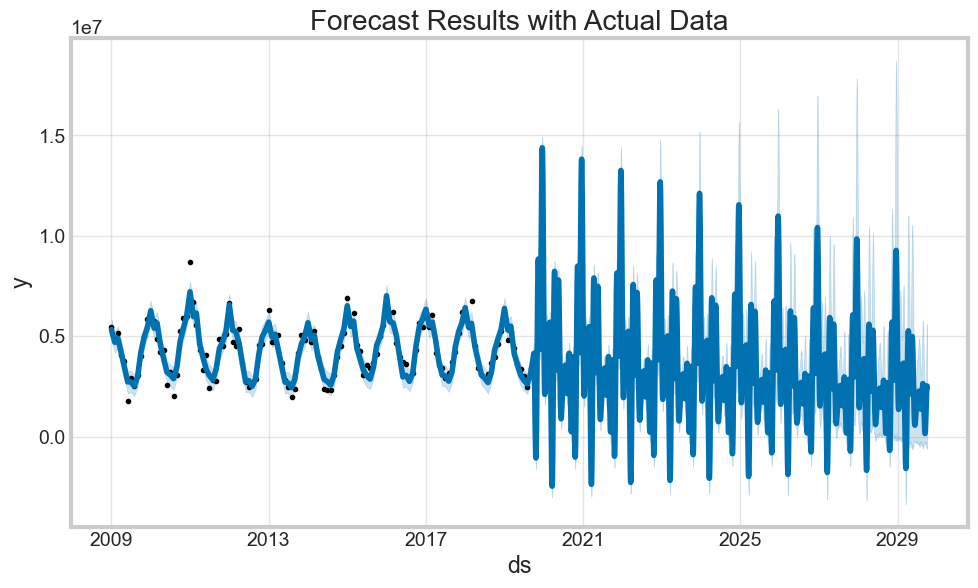

In [18]:
model.plot(forecast)
plt.title("Forecast Results with Actual Data")
plt.show()

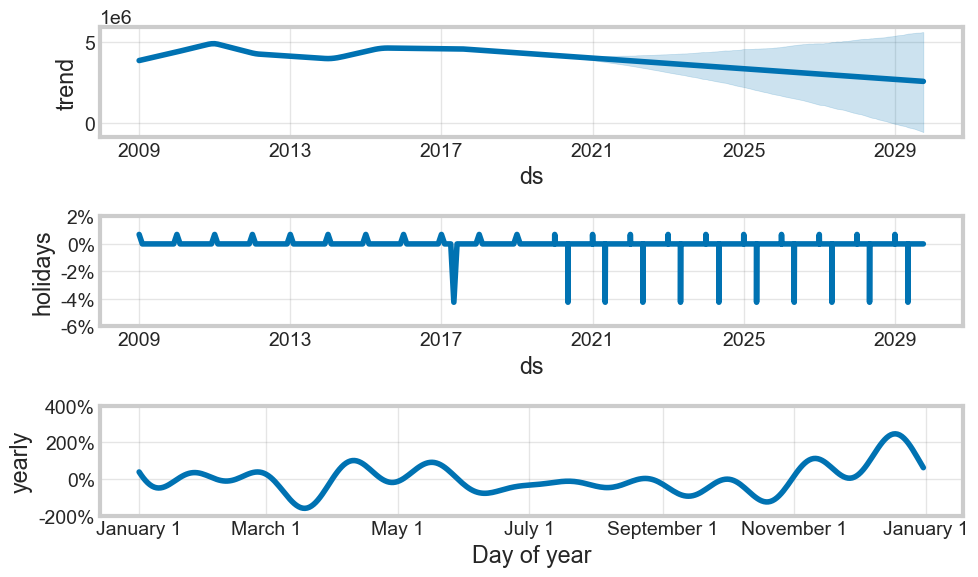

In [19]:
fig = model.plot_components(forecast, figsize=(10, 6))

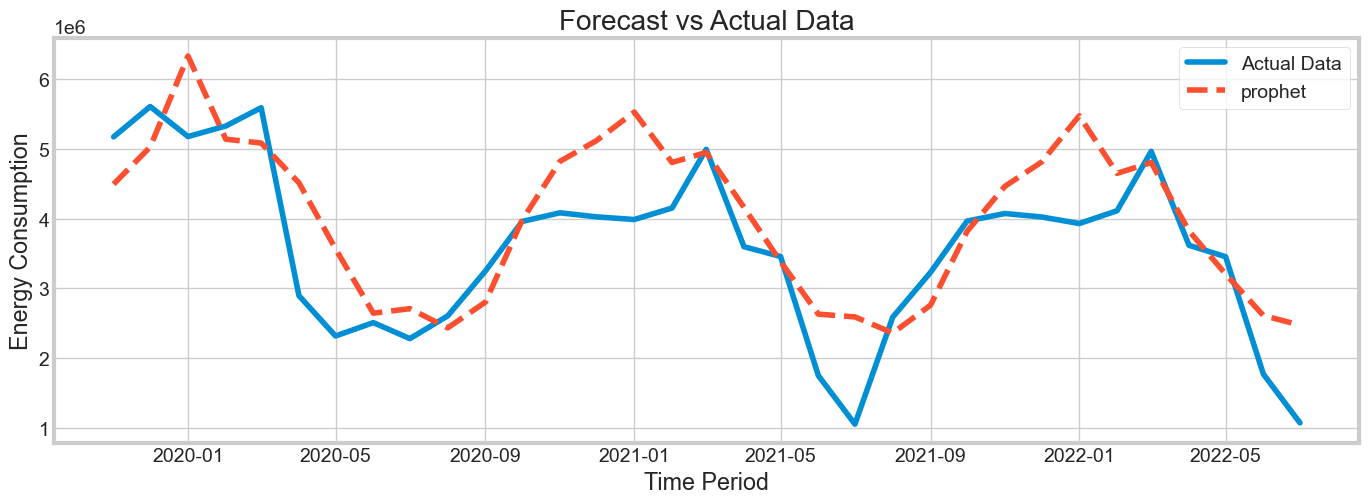

In [20]:
compare_df = pd.merge(forecast[['ds', 'yhat']], test_data, on='ds', how='inner')

plt.figure(figsize=(15, 5))
plt.plot(compare_df['ds'], compare_df['y'], label='Actual Data')
plt.plot(compare_df['ds'], compare_df['yhat'], label='prophet', linestyle='dashed')
plt.xlabel('Time Period')
plt.ylabel('Energy Consumption')
plt.title("Forecast vs Actual Data")
plt.legend()
plt.show()

# evaluation

In [21]:
mape_value, smape_value, mae_value, rmse_value = eval_metrics(compare_df['y'], compare_df['yhat'])
print(f"MAPE: {mape_value:.2f}")
print(f"SMAPE: {smape_value:.2f}")
print(f"MAE: {mae_value:.2f}")
print(f"RMSE: {rmse_value:.2f}")

MAPE: 25.19
SMAPE: 19.79
MAE: 644873.69
RMSE: 809373.66


# cross validation

In [22]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='500 days', period='180 days', horizon='50 days')
# print(df_cv.head())

  0%|          | 0/19 [00:00<?, ?it/s]

13:28:22 - cmdstanpy - INFO - Chain [1] start processing
13:28:36 - cmdstanpy - INFO - Chain [1] done processing
13:28:36 - cmdstanpy - INFO - Chain [1] start processing
13:29:15 - cmdstanpy - INFO - Chain [1] done processing
13:29:15 - cmdstanpy - INFO - Chain [1] start processing
13:29:16 - cmdstanpy - INFO - Chain [1] done processing
13:29:16 - cmdstanpy - INFO - Chain [1] start processing
13:29:17 - cmdstanpy - INFO - Chain [1] done processing
13:29:17 - cmdstanpy - INFO - Chain [1] start processing
13:29:18 - cmdstanpy - INFO - Chain [1] done processing
13:29:18 - cmdstanpy - INFO - Chain [1] start processing
13:29:19 - cmdstanpy - INFO - Chain [1] done processing
13:29:19 - cmdstanpy - INFO - Chain [1] start processing
13:29:20 - cmdstanpy - INFO - Chain [1] done processing
13:29:20 - cmdstanpy - INFO - Chain [1] start processing
13:29:23 - cmdstanpy - INFO - Chain [1] done processing
13:29:23 - cmdstanpy - INFO - Chain [1] start processing
13:29:25 - cmdstanpy - INFO - Chain [1]

In [23]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,5 days,3.752612e+11,6.125857e+05,4.265875e+05,0.097465,0.035513,0.088577,0.333333
1,6 days,4.866911e+11,6.976325e+05,5.669221e+05,0.119177,0.100649,0.112274,0.333333
2,8 days,5.145553e+11,7.173251e+05,6.490980e+05,0.131030,0.100649,0.124324,0.166667
3,10 days,4.772636e+11,6.908426e+05,6.863900e+05,0.147212,0.164000,0.150575,0.000000
4,11 days,1.811956e+12,1.346089e+06,1.247538e+06,0.235606,0.176987,0.272314,0.000000


# References
https://facebook.github.io/prophet/docs/diagnostics.html </br>
https://www.kaggle.com/code/manovirat/timeseries-using-prophet-hyperparameter-tuning </br>
https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html </br>